# CTCF L pos & neg (5%) | rle_max init | rle & 3-mer features

In [1]:
library(ggplot2)
library(data.table)
library(plyr)
library(dplyr)
library(tictoc)
library(ggsci)
library(purrr)
library(scales)
library(stringr)
library(cowplot)
library(gridExtra)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tictoc’


The following object is masked from ‘package:data.table’:

    shift



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact


The following object is masked from ‘package:data.table’:

    transpose


The following object is masked from ‘package:jsonlite’:

    flatten



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
while (!is.null(dev.list()))  dev.off()
rm(list=ls())

#------------ Helper Functions ------------
# Initiate PDF
openPDF <- function (output_file_fh, pdf_dims) {
  print(sprintf("Saving plots to: %s", output_file_fh))
  # Open PDF
  pdf(output_file_fh, width = pdf_dims[1], height = pdf_dims[2],
      useDingbats=FALSE, family = "ArialMT")
}

# Close PDF
closePDF <- function () {
  while (!is.null(dev.list()))  dev.off()
  print("File saved.")
}

In [3]:
#------------ Define dirs ------------
setwd("/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting")

#ARGS
data_folder <- sprintf("%s/candidate_footprints", getwd())
mokapot_dir <- sprintf("%s/mokapot_res", getwd())
output_folder <- sprintf("%s/figures", mokapot_dir)

## formatting data

In [5]:
# set args
motif_type <- "L"
input_file_root <- "rle_max-filt"
file_root <- "rle_max-filt" # for output file & titles
ctcf_dist <- c(-100,100)
n_rows <- Inf

# load set data file
data_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq.txt", input_file_root)
data_file <- sprintf("%s/%s", mokapot_dir, data_file_name)
print(data_file)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/CTCF_rle_max-filt.mokapot.m6a_fiberseq.txt"


In [6]:
# read table
df <- fread(data_file, nrows=n_rows)
sprintf("m6a rows: %s", format(dim(df)[1], big.mark=",", scientific=FALSE))

[1] "m6a rows: 14,950,168"

In [7]:
df <- df %>%
    mutate(Label = ifelse(Label == 1, "Positive", "Negative"))

table(df$Label)


Negative Positive 
 8040195  6909973 

In [7]:
df$FDR_05 <- ifelse(df$FDR < 0.05, "low_FDR", "high_FDR")
df$FDR_01 <- ifelse(df$FDR < 0.01, "low_FDR", "high_FDR")
df$FDR_001 <- ifelse(df$FDR < 0.001, "low_FDR", "high_FDR")
df$FDR_0001 <- ifelse(df$FDR < 0.0001, "low_FDR", "high_FDR")

In [8]:
# unique CTCF motifs, queries, & motif_queries
sprintf("unique motifs: %s", format(length(unique(df$motif_name)), big.mark=",", scientific=FALSE))
sprintf("unique queries: %s", format(length(unique(df$query_name)), big.mark=",", scientific=FALSE))
sprintf("unique motif-query groups: %s", format(length(unique(df$motif_query)), big.mark=",", scientific=FALSE))

[1] "unique motifs: 260,939"

[1] "unique queries: 365,077"

[1] "unique motif-query groups: 514,540"

In [9]:
# save original df
df_og <- df

## plot & color args

In [10]:
# change plot dimensions
options(repr.plot.width=20, repr.plot.height=10)

set_plot_dimensions <- function(width_choice, height_choice) {
options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }
set_plot_dimensions(15, 7.5)

In [11]:
# create density plot
font_size <- 12
font_info <- element_text(size=font_size, family="ArialMT", color="black")

In [12]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
motif_annot_col <- "#006738"#"#6C9272"#"blue"

# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")

## m6a density plots

### positive vs. negative

In [20]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq_density-pos_v_neg.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_rle_max-filt.mokapot.m6a_fiberseq_density-pos_v_neg.pdf"


In [15]:
# set y-lim
y_limits <- c(0, NA)
x_limits <- c(-100, 100)

plot_title <- sprintf("CTCF m6a density pos vs negative sets\n%s | rle & kmers | m6A pos: %s | m6A neg: %s", 
                      "Pos & 5% L neg",
                      format(table(df$Label)["Positive"], big.mark=",", scientific=FALSE), 
                      format(table(df$Label)["Negative"], big.mark=",", scientific=FALSE))
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- "aggregate m6a methylation density"

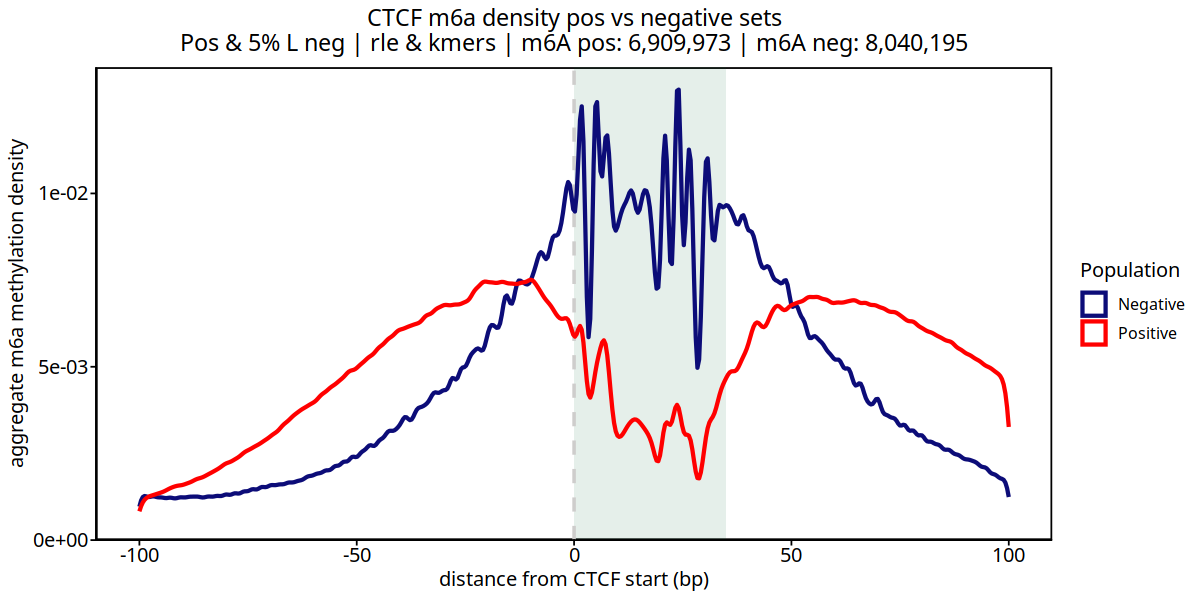

In [21]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])} else {set_plot_dimensions(10, 5)}
# pos: red, neg: blue
color_vals <- c(mitch_cols[5], mitch_cols[2])

p <- ggplot(df, aes(x=centered_start, group=Label)) +
        # add box over motif location
        annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.1, fill=motif_annot_col) +
        # add vertical line at x=0
        geom_vline(xintercept=0, color="#CECDCC", show.legend=FALSE, linetype="dashed", linewidth=1) +
        # density plot
        geom_density(aes(col=Label), size=1.2, adjust=0.5) +
        # red, blue
        scale_color_manual(name="Population", values=color_vals, labels=c("Negative", "Positive")) +
        scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0,0.05)), name=y_axis_name,
                           labels = function(x) format(x, scientific=TRUE), 
                           guide=guide_axis(check.overlap=TRUE)) +
    
        ggtitle(plot_title) +
        scale_x_continuous(name=x_axis_name) +
        theme_classic() +
        theme(text = font_info,
              axis.ticks = element_line(color="#000000", lineend="square"),
              axis.text = font_info,
              panel.background = element_rect(fill="transparent", color="#000000", size=1),
              plot.title = element_text(family="ArialMT", size=font_size+2, hjust=0.5))
p
                       
if (save_pdf == TRUE) {ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])}

### FDR filt

In [24]:
# filter for positive data
pos <- df[df$Label == "Positive"]

In [15]:
# plot m6a density grouped by FDR
plot_m6a_density <- function(df, FDR) {

    df$FDR_group <- ifelse(df$FDR < FDR, "low_FDR", "high_FDR")
    df$FDR_group <- factor(df$FDR_group, levels=c("low_FDR", "high_FDR"))
    FDR_str <- strsplit(as.character(FDR), ".", fixed=TRUE)[[1]][2]
    
    # set limits
    y_limits <- c(0, NA)
    x_limits <- c(-100, 100)
    plot_title <- sprintf("Aggregate m6a density (FDR < %s) - %s", FDR, "L Pos & 5% Neg")
    plot_subtitle <- sprintf("FDR low: %s | FDR high: %s", 
                        format(table(df$FDR_group)["low_FDR"], big.mark=",", scientific=FALSE), 
                        format(table(df$FDR_group)["high_FDR"], big.mark=",", scientific=FALSE))
    x_axis_name <- "distance from motif start"
    y_axis_name <- "aggregate m6a methylation density"
    legend_title <- "FDR"
    legend_labels <- c(sprintf("FDR < %s", FDR), sprintf("FDR > %s", FDR))
    
    # color values - low FDR (tf w/o m6a's) red | high FDR (accessible w/ m6a's) blue
    df$FDR_colors <- ifelse(df$FDR_group == "low_FDR", "#FF0000", "#0C0C78")
    df$FDR_colors <- factor(df$FDR_colors, levels=c("#FF0000", "#0C0C78"))
    motif_annot_col <- "#006738"
    vline_col <- "#CECDCC"
    font_size <- 12
    font_info <- element_text(size=font_size, family="ArialMT", color="black")
    
    # plot
    p <- ggplot(df, aes(x=centered_start, group=FDR_group)) +
            # add box over motif location
            annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.1, fill=motif_annot_col) +
            # add vertical line at x=0
            geom_vline(xintercept=0, color=vline_col, show.legend=FALSE, linetype="dashed", linewidth=1) +
            # density plot
            geom_density(aes(col=FDR_colors), size=1.2, adjust=0.5) +
            scale_color_identity(guide="legend", legend_title, 
                                 labels=legend_labels, breaks=levels(df$FDR_colors)) +
            #scale_color_manual(name="FDR", values=df$FDR_colors, labels=legend_labels) +
            scale_y_continuous(limits=y_limits, expand=expansion(mult=c(0,0.05)), name=y_axis_name,
                               labels = function(x) format(x, scientific=FALSE), 
                               guide=guide_axis(check.overlap=TRUE)) +
            ggtitle(label = plot_title, subtitle = plot_subtitle) +
            scale_x_continuous(name=x_axis_name) +
            theme_classic() +
            theme(text = font_info,
                  axis.ticks = element_line(color="#000000", lineend="square"),
                  axis.text = font_info,
                  panel.background = element_rect(fill="transparent", color="#000000", size=1),
                  plot.title = element_text(family="ArialMT", size=font_size+2, hjust=0.5),
                  plot.subtitle = element_text(family="ArialMT", size=font_size+2, hjust=0.5))
    
    return(p)
    
}

In [13]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq_density-pos_FDR_filters.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file?
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_rle_max-filt.mokapot.m6a_fiberseq_density-pos_FDR_filters.pdf"


In [18]:
# FDR values to plot
FDR_vals <- c(0.05, 0.01, 0.001)

save_pdf <- TRUE
if (save_pdf == TRUE) {openPDF(output_file, pdf_dims)} else {set_plot_dimensions(10, 5)}

for (FDR in FDR_vals) {
    cat("Making agg. m6a density plot for FDR: ", FDR)
    p <- plot_m6a_density(subset(df, Label="Positive"), FDR=FDR)
    print(p)
    cat("\n")
}

closePDF()

[1] "Saving plots to: /mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_rle_max-filt.mokapot.m6a_fiberseq_density-pos_FDR_filters.pdf"
Making agg. m6a density plot for FDR:  0.05[1] "\n"
Making agg. m6a density plot for FDR:  0.01[1] "\n"
Making agg. m6a density plot for FDR:  0.001[1] "\n"
[1] "File saved."


## Per fiber m6a plots

In [27]:
res <- df_og
dim(res)

[1] 14950168       18

In [28]:
#------------ Example motif data ------------

# load data file
data_file_name <- "CTCF_m6a_fiberseq_100bp_fig_example_positive.txt"
data_file <- sprintf("%s/%s", data_folder, data_file_name)
print(data_file)

# read table
df <- fread(data_file)
dim(df)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/candidate_footprints/CTCF_m6a_fiberseq_100bp_fig_example_positive.txt"


[1] 2165   13

In [29]:
# add motif_name row
df$motif_name <- paste(df$chrom, df$centering_position, df$strand, sep="_")
# move motif_name to first column
df <- df %>%
    select("motif_name", everything())

# add motif_query column
df <- cbind(paste(df$motif_name, df$query_name, sep="/"), df)
# rename column
colnames(df)[1] = "motif_query"

In [30]:
# get only m6a
df <- df[df$centered_position_type %in% c("m6a")]
# filter our rows with N in sequence
df <- df %>% filter(!(grepl("N", subset_sequence)))

In [31]:
# get moka res for motif-query values in example
moka <- filter(res, motif_query %in% df$motif_query)
dim(moka)

[1] 1005   18

In [32]:
moka

motif_query,motif_name,chrom,centering_position,strand,subset_sequence,reference_start,reference_end,query_name,centered_query_start,centered_query_end,query_length,centered_position_type,centered_start,centered_end,msp_size,Label,FDR
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<dbl>
chr20_63786415_+/m54329U_210326_192251/159909932/ccs,chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-67,-66,203,Positive,0.04623195
chr20_63786415_+/m54329U_210326_192251/159909932/ccs,chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-64,-63,203,Positive,0.04623195
chr20_63786415_+/m54329U_210326_192251/159909932/ccs,chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-63,-62,203,Positive,0.04623195
chr20_63786415_+/m54329U_210326_192251/159909932/ccs,chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-57,-56,203,Positive,0.04623195
chr20_63786415_+/m54329U_210326_192251/159909932/ccs,chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-56,-55,203,Positive,0.04623195
chr20_63786415_+/m54329U_210326_192251/159909932/ccs,chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-53,-52,203,Positive,0.04623195
chr20_63786415_+/m54329U_210326_192251/159909932/ccs,chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-52,-51,203,Positive,0.04623195
chr20_63786415_+/m54329U_210326_192251/159909932/ccs,chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-51,-50,203,Positive,0.04623195
chr20_63786415_+/m54329U_210326_192251/159909932/ccs,chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-47,-46,203,Positive,0.04623195


In [33]:
# get max rle per fiber
#ARGS
feature_dir <- sprintf("%s/feature_data", getwd())

# load set data file
data_file_name <- "CTCF_m6a_fiberseq_L_100bp_features-rle-max.pin"
data_file <- sprintf("%s/%s", feature_dir, data_file_name)
print(data_file)

# read table
df_f <- fread(data_file, nrows=n_rows)
sprintf("m6a rows: %s", format(dim(df_f)[1], big.mark=",", scientific=FALSE))

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_features-rle-max.pin"


[1] "m6a rows: 569,891"

In [34]:
# add max rle to table w/ FDRs
names(df_f)[names(df_f) == "SpecID"] <- "motif_query"
moka <- merge(moka, df_f[,c("motif_query", "rle_max")], by="motif_query")

In [35]:
# plot m6a instances in coords
motif_coords <- c("chr20", 63786415, 63786450)

In [36]:
dim(moka)

[1] 1005   19

### FDR gradient

In [66]:
# make plotting data
df_p <- moka[, c("motif_query", "motif_name", "query_name", "centered_start", "centered_end", "FDR", "rle_max")]

In [109]:
#------------ Set output file ------------
FDR <- 0.05
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_per_fiber_log2_FDR.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(15,7.5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_rle_max-filt.mokapot.m6a_per_fiber_log2_FDR.pdf"


In [110]:
# sort by FDR value
df_p <- df_p[order(df_p$FDR, decreasing=TRUE)]

# add col with y-axis coords
y_min <- seq(from=0, by=1, length.out=length(unique(df_p$query_name)))
y_max <- seq(from=0.75, by=1, length.out=length(unique(df_p$query_name)))

y_min_vals <- setNames(y_min, unique(df_p$query_name))
y_max_vals <- setNames(y_max, unique(df_p$query_name))

df_p <- df_p %>%
            mutate(
                y_min = y_min_vals[query_name],
                y_max = y_max_vals[query_name]
            )

# get plot limits
x_min <- max(df_p$centered_start)
x_max <- min(df_p$centered_end)
# number of fibers
n_fibers <- length(unique(df_p$query_name))

In [111]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
motif_annot_col <- "#006738"#"#6C9272"#"blue"

# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[2], mitch_cols[5])

# add color based on FDR value
df_p$fill_col <- ifelse(df_p$FDR <= FDR, color_vals[1], color_vals[2])
df_p$FDR_group <- ifelse(df_p$FDR <= FDR, "low_FDR", "high_FDR")

In [112]:
# make plot & axes titles
cat(length(unique(df_p$query_name)))
y_limits <- c(0, length(unique(df_p$query_name)))
x_limits <- c(-100, 100)
plot_title <- sprintf("m6A methylation per fiber over %s: %s - %s (log2 FDR)",
                      motif_coords[1],
                      format(as.numeric(motif_coords[2]), big.mark=",", scientific=FALSE),
                      format(as.numeric(motif_coords[3]), big.mark=",", scientific=FALSE))
plot_subtitle <- sprintf("%s | init: rle_max | rle & k-mers | %s fibers", 
                         "Pos & 5% L neg", length(unique(df_p$query_name)))

x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- "individual fibers"

31

In [113]:
if (save_pdf == TRUE) {openPDF(output_file, pdf_dims)} else {set_plot_dimensions(15, 5)}

# make background fiber smaller than m6a mark
squish_fiber <- 0.15

# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[2], mitch_cols[5])

# plot (colored by FDR)
p <- ggplot(df_p) +
        # add box over motif location
        annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.2, fill=motif_annot_col) +
        geom_rect(aes(xmin=-100, xmax=101, ymin=(y_min+squish_fiber), ymax=(y_max-squish_fiber)), 
                  fill=fiber_col, data=df_p) +
        geom_rect(aes(xmin=centered_start, xmax=centered_end, 
                      ymin=y_min, ymax=y_max, group=FDR_group, fill=FDR), data=df_p) +
        scale_fill_gradient(low = "red", high = "blue", trans = "log2", 
                            expand = expansion(mult=c(0.5, 0.5)), n.breaks=5, 
                            guide = guide_colorbar(barwidth=1, draw.ulim=TRUE, draw.llim=TRUE, title="log2 FDR"), 
                            labels = function(x) format(round(x, 3), nsmall=2, scientific=FALSE)) +
                            
        ggtitle(label = plot_title, subtitle = plot_subtitle) +
        scale_y_continuous(expand=expansion(add=c(0,0)), name=y_axis_name) +
        scale_x_continuous(name=x_axis_name, expand=expansion(add=c(0, 5))) +
        theme_classic() +
        theme(text = font_info,
            axis.ticks = element_line(color="#000000", lineend="square"),
            axis.text = font_info,
            axis.line = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(family="ArialMT", size=font_size+2, hjust=0.5),
            plot.subtitle = element_text(family="ArialMT", size=font_size+2, hjust=0.5),
             plot.margin=margin(1,0,1,1, "pt"))
p

#if (save_pdf == TRUE) {closePDF()}

[1] "Saving plots to: /mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_rle_max-filt.mokapot.m6a_per_fiber_log2_FDR.pdf"


[1] "File saved."


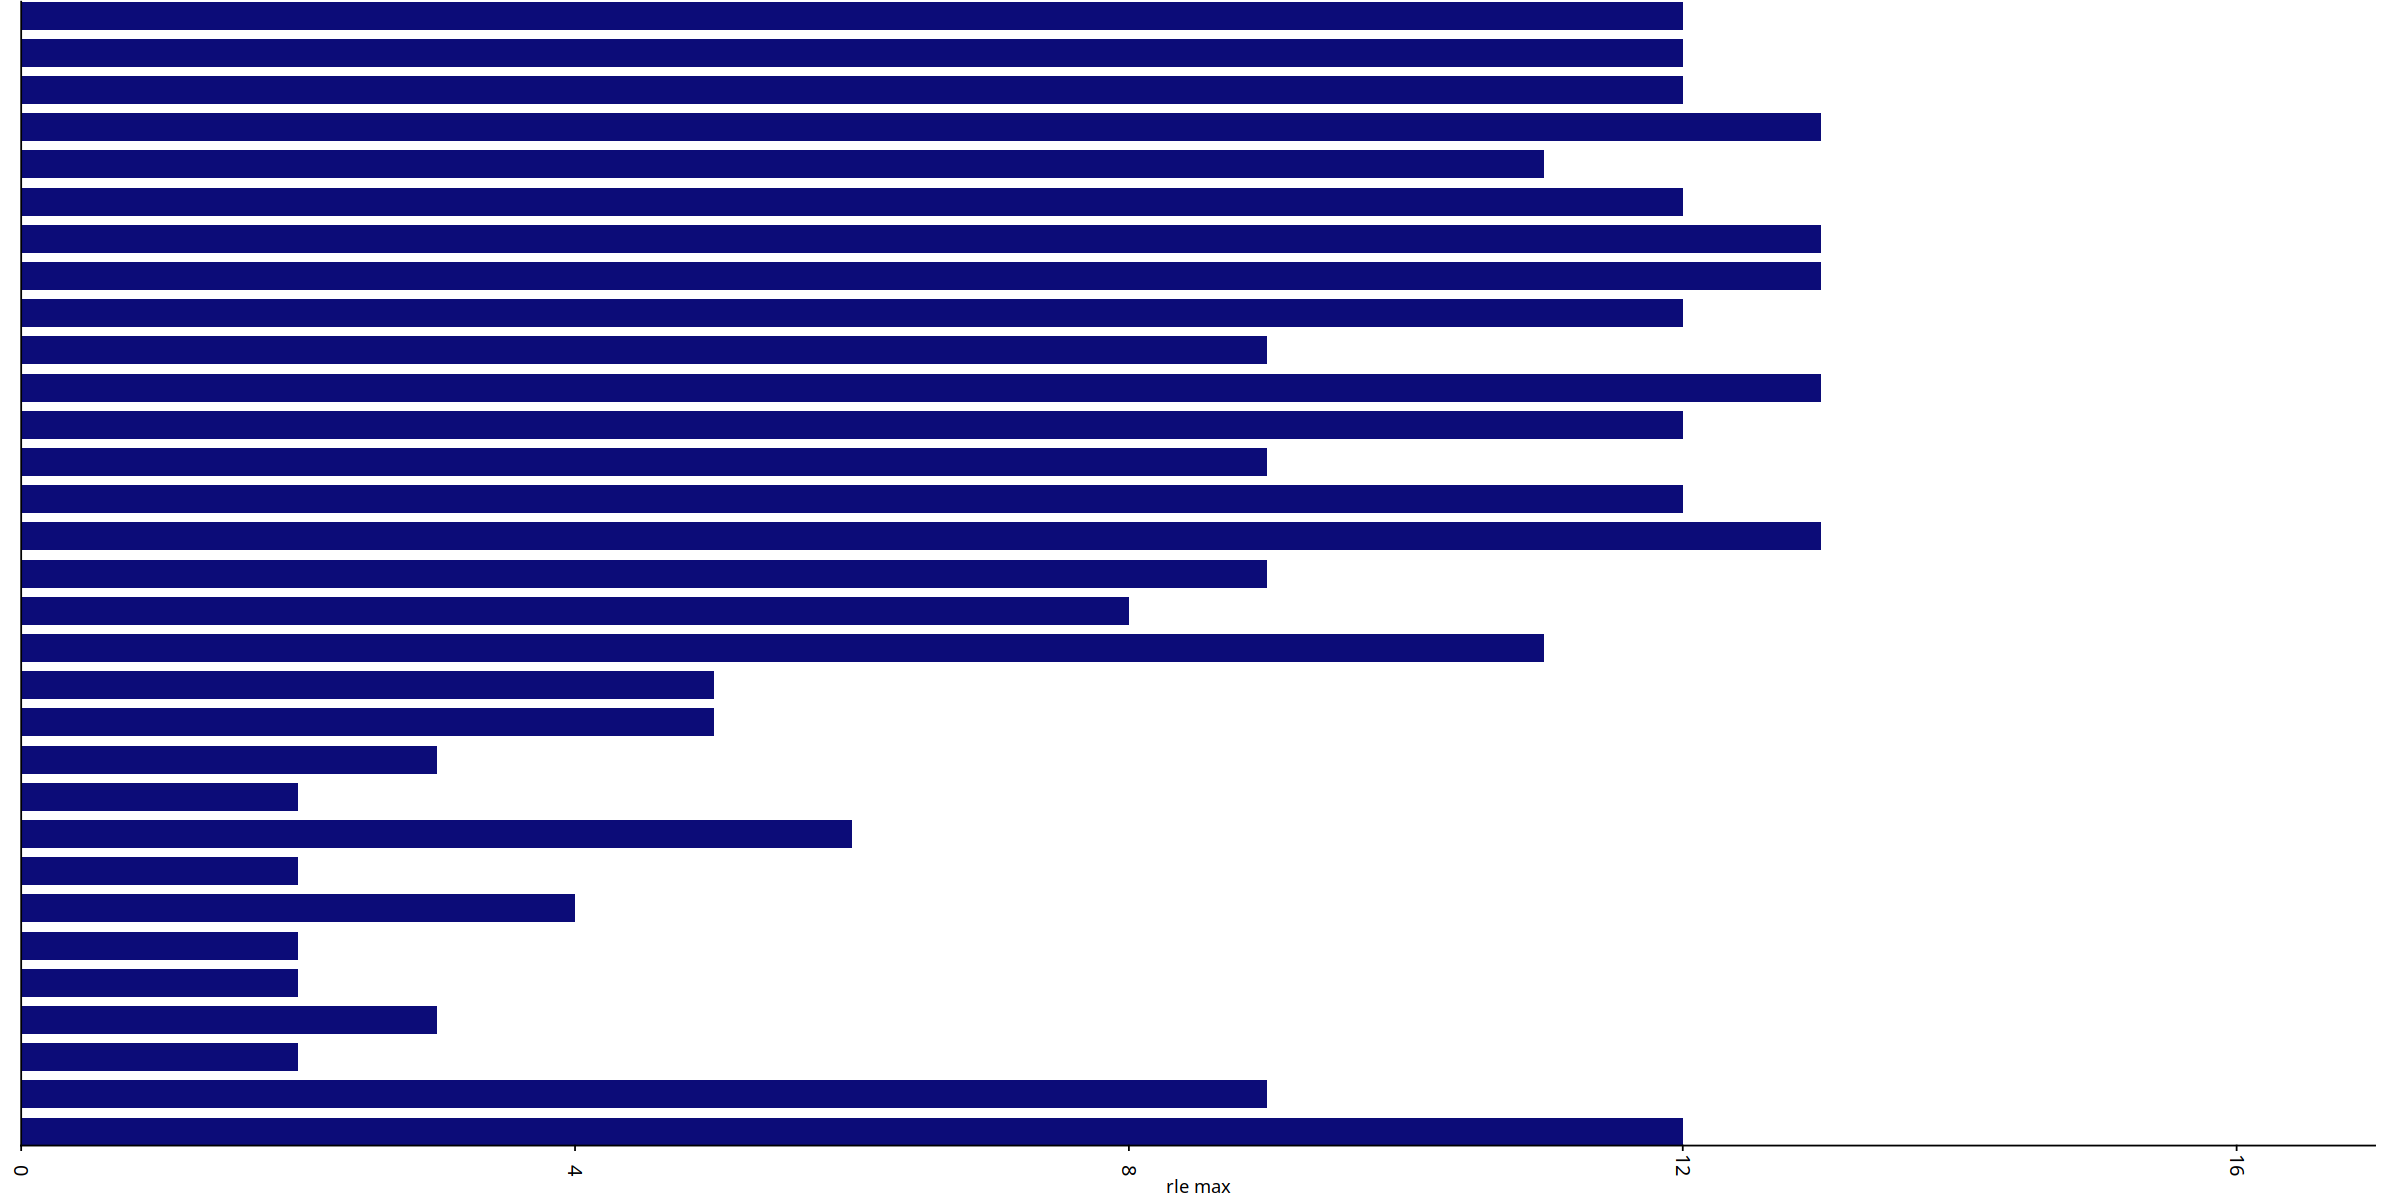

In [114]:
# make rle max bar larger than m6a mark
rle_stretch <- 0

p2 <- ggplot(df_p) +
        geom_rect(aes(xmin=0, xmax=rle_max, ymin=(y_min)-rle_stretch, ymax=(y_max+rle_stretch)),
                  fill=mitch_cols[5]) +
        #geom_text(aes(label=rle_max, x=-2, y=(y_min-0.2)), vjust=0, hjust=1, 
        #          size=2, family="ArialMT", color="black", face="plain") +
        scale_y_continuous(expand=expansion(add=c(0,NA))) +#, breaks=1:49, labels=labels) +#, limits=c(-0.5,49)) +
        scale_x_continuous(limits=c(-3, 17), expand=c(0,0), position="bottom", name="rle max") +
        coord_cartesian(xlim=c(0, 17), clip="off") +
        theme_classic() +
        theme(#text = font_info,
                axis.ticks = element_line(color="#000000", lineend="square"),
                axis.text.x = element_text(angle=-90, hjust=1, vjust=0.5,
                                           size=12, family="ArialMT", color="black"),
                axis.text.y=element_blank(),
                axis.ticks.y=element_blank(),
                axis.title.y=element_blank(),
                axis.line = element_line(color="#000000", lineend="square"),
                #panel.background = element_rect(fill="transparent", color="#000000", size=1),
                legend.position = "none",
                plot.margin = margin(t=1, r=15, b=1, l=10))

p2

if (save_pdf == TRUE) {closePDF()}

In [117]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_per_fiber_log2_FDR_rle-max.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(15,7.5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_rle_max-filt.mokapot.m6a_per_fiber_log2_FDR_rle-max.pdf"


In [118]:
if (save_pdf == TRUE) {openPDF(output_file, pdf_dims)} else {set_plot_dimensions(15, 5)}

# merge plots
p3 <- plot_grid(p, NULL, p2, rel_widths = c(0.925, -0.1, 0.075), nrow=1, align="h")
p3

if (save_pdf == TRUE) {closePDF()}

[1] "Saving plots to: /mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_rle_max-filt.mokapot.m6a_per_fiber_log2_FDR_rle-max.pdf"
[1] "File saved."
